This Notebook is split into two parts:

# 1. Data consistency review & feature engineering
# 2. Insights discovery & visualizations


In [96]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import datetime as dt
import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


import seaborn as sns

## 1. Data consistency review & feature engineering

<ul>
<li>Delivery time date is inconsistent or missing in some cases.
Some of this can be fixed or feature engineered to some extent, however both delivery start time and delivery end time are missing in 10% of the records.
The “how_long_it_took_to_order” attribute seem also inconsistent with the existing delivery start and final drop off dates.
<li>Place category classification is not consistent. Higher level classification labels (e.g. "Restaurant") are mixed with lower level classification labels ("Burger") and these are not necessarily mutually exclusive ("American" vs "Burger" or "Japanese" and "Sushi")
</ul>



In [97]:
#read csv to df

df=pd.read_csv("analyze_me.csv")


In [98]:
df.shape

(5983, 18)

In [99]:
#fix/fill nulls

df.isnull().sum(axis=0)

delivery_id                               0
customer_id                               0
jumpman_id                                0
vehicle_type                              0
pickup_place                              0
place_category                          883
item_name                              1230
item_quantity                          1230
item_category_name                     1230
how_long_it_took_to_order              2945
pickup_lat                                0
pickup_lon                                0
dropoff_lat                               0
dropoff_lon                               0
when_the_delivery_started                 0
when_the_Jumpman_arrived_at_pickup      550
when_the_Jumpman_left_pickup            550
when_the_Jumpman_arrived_at_dropoff       0
dtype: int64

In [100]:
#only 50% of records show time of order

df.isnull().sum()/len(df)*100


delivery_id                             0.000000
customer_id                             0.000000
jumpman_id                              0.000000
vehicle_type                            0.000000
pickup_place                            0.000000
place_category                         14.758482
item_name                              20.558248
item_quantity                          20.558248
item_category_name                     20.558248
how_long_it_took_to_order              49.222798
pickup_lat                              0.000000
pickup_lon                              0.000000
dropoff_lat                             0.000000
dropoff_lon                             0.000000
when_the_delivery_started               0.000000
when_the_Jumpman_arrived_at_pickup      9.192713
when_the_Jumpman_left_pickup            9.192713
when_the_Jumpman_arrived_at_dropoff     0.000000
dtype: float64

In [101]:
#overall quantity is low therefore missing values can be replaced with average

df.loc[:,"item_quantity"].mean()

1.2482642541552704

In [102]:
#transforming objects into datetime for further analysis

df['when_the_delivery_started'] = df['when_the_delivery_started'].astype('datetime64[ns]') 
df['when_the_Jumpman_arrived_at_pickup'] = df['when_the_Jumpman_arrived_at_pickup'].astype('datetime64[ns]') 
df['when_the_Jumpman_arrived_at_dropoff'] = df['when_the_Jumpman_arrived_at_dropoff'].astype('datetime64[ns]') 
df['when_the_Jumpman_left_pickup'] = df['when_the_Jumpman_left_pickup'].astype('datetime64[ns]') 


In [103]:
#feature engineering driving time

df['driving_time']=df['when_the_Jumpman_arrived_at_dropoff']-df['when_the_Jumpman_arrived_at_pickup']

In [104]:
#feature engineering order time

df['order_time']=df['when_the_Jumpman_arrived_at_dropoff']-df['when_the_delivery_started']

In [105]:
#added feature engineering - driving time and overall length of order

df.describe()

delivery_id    customer_id     jumpman_id  item_quantity   pickup_lat  \
count  5.983000e+03    5983.000000    5983.000000    4753.000000  5983.000000   
mean   1.379495e+06  176472.595521  102661.602541       1.248264    40.741425   
std    6.459397e+04  116414.487842   48607.211795       0.785904     0.022833   
min    1.271706e+06     242.000000    3296.000000       1.000000    40.665611   
25%    1.322792e+06   77817.000000   60761.000000       1.000000    40.724340   
50%    1.375689e+06  131093.000000  113364.000000       1.000000    40.735677   
75%    1.436371e+06  293381.000000  143807.000000       1.000000    40.758726   
max    1.491424e+06  405547.000000  181543.000000      16.000000    40.818082   

        pickup_lon  dropoff_lat  dropoff_lon            driving_time  \
count  5983.000000  5983.000000  5983.000000                    5433   
mean    -73.987101    40.744216   -73.985765  0 days 00:33:03.080986   
std       0.014896     0.025251     0.018060  0 days 00:15:54.443556   
min     -74.015837    40.649356   -74.017679  0 days 00:05:17.494591   
25%     -73.996630    40.725307   -74.000297  0 days 00:22:08.276113   
50%     -73.988682    40.740424   -73.989280  0 days 00:29:41.092550   
75%     -73.980739    40.763885   -73.974696  0 days 00:40:19.531874   
max     -73.920980    40.848324   -73.924124  0 days 05:36:58.112044   

                   order_time  
count                    5983  
mean   0 days 00:46:04.870654  
std    0 days 00:20:13.598486  
min    0 days 00:03:02.830850  
25%    0 days 00:32:40.034945  
50%    0 days 00:42:40.486114  
75%    0 days 00:55:07.618052  
max    0 days 05:40:18.528600

In [106]:
#feature engineering: calculate distance between pickup and dropoff points.
#this could come handy when trying to correlate business performance with average distance or clustering shops by local market

from geopy.distance import distance

dropoff_lat = df['dropoff_lat'].tolist()
dropoff_lon = df['dropoff_lon'].tolist()
pickup_lat = df['pickup_lat'].tolist()
pickup_lon = df['pickup_lon'].tolist()

d=[]
i=1

for i in range(0,5983):
    km=(distance(dropoff_lat[i]+dropoff_lon[i], pickup_lat[i]+pickup_lon[i]))
    print(km)
    d.append(km)

#adding distance series into original dataframe

df['distance'] = pd.Series(d)


1.4238305829235915 km
0.06659499068441907 km
0.3744932349177872 km
1.0540158571549147 km
3.3451565028316645 km
1.6128191026975929 km
1.1648042307476956 km
0.8090716701797122 km
0.4939893383766355 km
0.3756816796145575 km
2.7948500436103614 km
1.2133637363890515 km
0.685504625695781 km
0.24205452632030822 km
3.9175834971683123 km
13.193310553507482 km
0.7984526098439184 km
4.103635766283575 km
1.7352806102740428 km
3.1417904211807968 km
0.04133388573882058 km
2.195527636363665 km
3.04503428321741 km
1.2729928186882722 km
1.0022674000606613 km
1.5590947435296416 km
0.11155176056623833 km
2.557901528122036 km
9.536411802521828 km
2.887931369731027 km
1.8913966081757512 km
7.573677388490033 km
1.0394395984845168 km
1.4288686259291117 km
1.0050955325740276 km
5.32012764181045 km
0.8192874815508653 km
1.9641431610110363 km
0.32941875059561954 km
0.10291416479781822 km
5.409264038036727 km
1.6337560391248256 km
0.40328302543433625 km
2.156119386954989 km
0.12817418975241465 km
2.1573353476478

0.8557304806675099 km
1.6452957427356727 km
4.277765020021999 km
0.05025436524297506 km
1.0702581952832735 km
4.245602588088551 km
2.78814740597097 km
4.45696849347856 km
2.1417190933293027 km
4.17794264845842 km
1.206202220646421 km
1.6076221422645731 km
0.1597675938657813 km
1.7711317984146229 km
2.6364392461510238 km
1.8367723155595883 km
4.850570661783238 km
0.2649791258479268 km
3.073632328997769 km
1.0766971610106617 km
0.8369524200851645 km
3.4654927301014156 km
0.5680228624945487 km
0.2343270814470105 km
2.579111281306874 km
7.326018814476756 km
0.14230631217044945 km
1.380719997664895 km
0.4004791934329016 km
0.3520007021031447 km
3.442656367126013 km
1.947706358427737 km
0.9390375456448384 km
1.2415387334188603 km
0.1368198021428119 km
0.32660883432035087 km
0.9807366616117202 km
0.4172278468530358 km
2.165674684611747 km
1.3670103022910356 km
2.7225863980606637 km
7.812173690907732 km
7.17893334972425 km
5.469576913558712 km
6.028986613848833 km
5.507446935555257 km
1.728164

3.629345469773694 km
1.8351737352118294 km
11.083957499817055 km
0.6831101207912849 km
0.7557237845766661 km
10.16803822306614 km
0.7331974132760296 km
0.6771731337629109 km
1.913268846975913 km
4.909262015067732 km
1.2729928186882722 km
6.010112377272058 km
0.011390356287253718 km
0.9778759041296092 km
0.5328627297962468 km
0.6231514833664842 km
1.9944515000786402 km
0.7218967287623164 km
2.215909631909847 km
4.8044562221942355 km
1.9731411686643732 km
2.2478274273238927 km
2.0520299294112085 km
0.4147725502543236 km
5.2344082181399285 km
0.542018834703696 km
1.6284346797106488 km
1.4155475202211851 km
2.6695143251933047 km
0.7120003556715212 km
0.2944644925246991 km
0.2835880662210738 km
1.3193858322723153 km
1.6023976593051001 km
0.23241437314533728 km
0.4343846014593968 km
1.5429924993485777 km
2.072758986359439 km
6.959108923848714 km
0.6301287070521433 km
1.092365276050708 km
1.0318358240851326 km
0.030626646200006928 km
5.281246555099088 km
1.1787368103134814 km
1.14680436493849

0.24133672281276 km
0.43904642809018696 km
0.2979325393285788 km
2.1386807030579496 km
2.024486675140545 km
0.5629611534323563 km
3.4256434642648377 km
0.5044628682746137 km
0.18834009089286788 km
1.8226448511762643 km
3.3384952984614866 km
2.55565651085708 km
9.080552531338263 km
1.3498442109791224 km
2.5305867084906244 km
1.7190319641244565 km
1.852767475541529 km
1.923923410281715 km
0.6270654453870007 km
3.969401381895123 km
3.857103146821815 km
0.27983995405121564 km
2.1601271938235516 km
4.610942096316285 km
0.49625795748726637 km
0.52792432423149 km
0.10158121994409898 km
0.8296504706032906 km
6.316705556314557 km
7.2212549273770055 km
0.6454685016084999 km
0.7295796411648131 km
1.3069113325279837 km
1.6165800087192124 km
0.6372553886921597 km
0.6728858523844973 km
1.5048152627432738 km
1.0491353868623972 km
1.4235783353148062 km
0.1341533904449282 km
1.1362758453722592 km
1.135349158156594 km
0.6614311976746984 km
2.646770568432775 km
0.5042041057416209 km
3.8463267576059135 km

0.29707561766568213 km
0.9300852689923668 km
0.9508909409459234 km
2.7004848191585102 km
4.163140114155691 km
0.9355128954847095 km
0.5555059963666169 km
3.538892670729778 km
0.23368534150019651 km
1.5013551767602327 km
1.5027186290513217 km
0.15020148347070705 km
0.7793378842366296 km
0.8940542934185804 km
1.7220627694549249 km
2.400614589531776 km
0.3818087329925594 km
0.41980790070974083 km
0.02329979032248031 km
0.016289263066716377 km
2.4369417413717414 km
2.6657704872760064 km
1.0986557835429966 km
1.111404352822377 km
2.6570507363834097 km
0.7242920130869615 km
1.0525521229132817 km
1.64552582730588 km
2.878337395535819 km
0.7797074676845114 km
2.646770568432775 km
1.7083346979821514 km
0.5657382704129011 km
2.9320159724547725 km
1.5092428482738445 km
0.38150478586936976 km
1.843986034834188 km
1.3326550466694835 km
3.467453040310365 km
1.9609607798514583 km
3.413858891083196 km
1.6339196054873306 km
4.085113027191896 km
1.8296322683040522 km
0.09704536034412205 km
1.50196258751

4.822214974434016 km
0.49113327876084684 km
6.2664945275936255 km
1.8852337385518558 km
0.2460965889215583 km
6.223016899448722 km
0.48406751747496524 km
0.05682569245771408 km
1.178600145170177 km
0.5214235865584398 km
0.352545979740168 km
2.056783954532372 km
4.820398086188528 km
2.168956252646248 km
3.7031171911635528 km
3.9388978138733064 km
2.9969658845468343 km
1.6120654155744092 km
0.17287396259095633 km
4.66670911344792 km
0.3182982368683601 km
2.9695165495610296 km
1.9708724291628987 km
3.676940301716533 km
2.2671858904150133 km
1.1869513958651796 km
0.22290771421880565 km
3.2436198224264543 km
0.48297757318725176 km
1.4796931032022747 km
1.6619337406285632 km
2.594827973743634 km
5.395767385164628 km
1.2898949421698136 km
0.1610899424344266 km
2.8381548750048995 km
5.909289522580357 km
1.9761284350262949 km
0.9857775641099531 km
3.4966111134837776 km
1.1367108382512703 km
2.3024272108882347 km
3.618873417756576 km
2.2535957183644753 km
1.4164229470697376 km
0.0516938255105531

9.612396616020357 km
1.9944515000786402 km
0.35610913840042085 km
9.838943683381787 km
2.061812005569876 km
3.65801192361481 km
2.5061454935879186 km
2.1253836451003734 km
1.6689045634964068 km
1.81686957348344 km
0.15915441520700752 km
6.087661186262113 km
2.034461593829482 km
0.5850581957466562 km
2.158521156279464 km
0.935416537918136 km
1.4929052129701892 km
4.6839286971240455 km
1.3325067735838894 km
4.653996630179263 km
1.358532722950382 km
0.6982560079016156 km
1.0904474299629687 km
1.3821245161134452 km
1.5635081663638788 km
1.5951896357891553 km
0.4852261515938168 km
2.7922035491355497 km
6.185705958748556 km
0.23258503379575002 km
3.2852407680892552 km
7.2734073473128324 km
0.9706007476751796 km
2.5687339872558526 km
4.36528654477043 km
1.8693315294464208 km
8.367748740482567 km
2.574835168590631 km
2.246974184064717 km
0.42939645898788753 km
1.98636366191609 km
0.4095611681970767 km
0.7716407655533366 km
0.7626288811780432 km
0.6023029060574707 km
1.0189601048987305 km
2.720

4.941799202716975 km
4.228688637173447 km
0.6649943060076347 km
4.150632885305232 km
0.5255053946252696 km
1.9568552585893992 km
0.700561107677111 km
0.9066432003935391 km
0.12242176641510444 km
0.5299879459293395 km
1.5086521980127527 km
2.3998445550421024 km
2.9815420515334727 km
1.7643640537102756 km
0.23401806203217132 km
3.4687045792831284 km
0.41243592193220024 km
1.0759591209845891 km
2.389672628685533 km
0.4889847373171109 km
0.7153037856306137 km
0.2633374647906659 km
0.4478709824309358 km
0.11181142972483053 km
1.9809751027076798 km
1.4643888297419483 km
2.228799316940725 km
1.0005824599394486 km
0.8413533708888532 km
0.01987484771802272 km
5.555049863328766 km
2.5687339872558526 km
0.49021340715200296 km
3.5877103048005856 km
0.5831782375971192 km
4.797572054944543 km
0.9978941490391363 km
4.45068589697642 km
3.6194675955608973 km
0.2870227240484886 km
0.288520567670686 km
7.311907075425057 km
0.26402499500251253 km
0.9261203408644464 km
1.0144539002614512 km
2.4633004746994

1.4902660172132993 km
2.2746376287931276 km
0.6140937672651249 km
0.3645947826573799 km
1.3686910585273637 km
0.05051230169500419 km
0.6866353198426673 km
0.5585909544467227 km
0.6765869060706495 km
1.9942964393054838 km
0.28223054062716313 km
0.8169354347827567 km
4.621919497087528 km
0.8817150292197965 km
1.9820427566916716 km
0.08068368204899772 km
6.608763530550734 km
4.293973823834497 km
0.791698408231911 km
7.065274869056744 km
3.5344542012279647 km
1.8367723155595883 km
1.882606600352503 km
0.6649943060076347 km
8.45309077831053 km
1.3735606377465497 km
8.557516029977702 km
0.8501274582302735 km
0.3070091678338173 km
7.509635568530199 km
0.6797441275847749 km
0.2517586606210906 km
1.1468043649384914 km
0.13564639647656002 km
0.5671455187157178 km
1.8016417252371557 km
3.4191080304442525 km
0.5297519470192752 km
2.2946977694553206 km
2.6054563560772697 km
0.6909305978245645 km
3.0345923258084553 km
1.385485997253106 km
2.2513776312172586 km
2.468910218440299 km
1.5847339685171886

1.538660355824992 km
1.0701292630037305 km
0.8098845624631397 km
5.361479556318252 km
2.3337686062071112 km
2.6983898783469322 km
7.441240212918636 km
0.058814804094824966 km
0.13732062019417077 km
3.532351563683433 km
1.0753229959100312 km
1.1236402336483544 km
3.0345923258084553 km
0.20294698927791327 km
0.15889711665349981 km
3.801595356157721 km
2.9851114572888315 km
7.5007349381659205 km
5.226377084769317 km
1.2600220882654924 km
2.0627433791682543 km
0.7833999547612718 km
3.420252634374002 km
0.40213952395185376 km
2.7459492314488947 km
3.152129653169644 km
3.197586072903322 km
1.9375284450973569 km
0.5076717390807058 km
1.9374456923688181 km
0.2782232520171965 km
0.9632704906466146 km
1.738068727000895 km
2.0636740414169203 km
0.3719568227838435 km
0.9218333429768907 km
7.5510226434320575 km
1.394888543199118 km
1.4188272619406055 km
0.5088091281961361 km
3.246296013459877 km
3.8968411098115654 km
0.8589668360449196 km
0.6699888704150986 km
0.8009891941373593 km
0.45512327062237

1.7083902356956986 km
0.600559161293193 km
1.7501080691442579 km
0.7675696926513115 km
4.04908584061603 km
2.0666492506307357 km
1.2865186072545323 km
1.1287325123965033 km
4.204064065897374 km
1.1028377106049612 km
0.37716243743131406 km
0.8803756954052896 km
2.0006385689015787 km
0.9173617073420308 km
0.8770554084526127 km
0.8164725223851875 km
7.285536898948215 km
3.2737283724301354 km
2.2391083539218357 km
0.07015918188953123 km
0.6725081156834306 km
5.845335682881653 km
2.5225314775821124 km
2.2426513935055596 km
0.06712614990199833 km
0.915392250372253 km
1.5022695278301292 km
1.7957459193928114 km
0.8514847271428841 km
0.27604608901061134 km
1.5708248825473574 km
1.0431423359169294 km
2.8841918544691225 km
0.9588870927984492 km
1.7292770331087601 km
8.464512146457617 km
2.885790510687547 km
1.214063472396594 km
0.23574607760702773 km
1.773216199459693 km
9.98308181147634 km
1.595677487366019 km
1.1477704451829371 km
1.0779699912430185 km
0.8187503805023176 km
1.8275336787224792 

In [107]:
#removing "km" from distance, casting into string and then into float for further processing

df['distance'] = df['distance'].astype(str).str[:-3].astype(float)


In [108]:
df.head()

delivery_id  customer_id  jumpman_id vehicle_type         pickup_place  \
0      1457973       327168      162381          van            Melt Shop   
1      1377056        64452      104533      bicycle  Prince Street Pizza   
2      1476547        83095      132725      bicycle           Bareburger   
3      1485494       271149      157175      bicycle          Juice Press   
4      1327707       122609      118095      bicycle    Blue Ribbon Sushi   

  place_category                    item_name  item_quantity  \
0       American                     Lemonade            1.0   
1          Pizza        Neapolitan Rice Balls            3.0   
2         Burger                   Bare Sodas            1.0   
3      Juice Bar      OMG! My Favorite Juice!            1.0   
4       Japanese  Spicy Tuna & Tempura Flakes            2.0   

     item_category_name how_long_it_took_to_order  ...  pickup_lon  \
0             Beverages           00:19:58.582052  ...  -73.990742   
1            Munchables           00:25:09.107093  ...  -73.994615   
2                Drinks           00:06:44.541717  ...  -73.998392   
3   Cold Pressed Juices                       NaN  ...  -74.002747   
4  Maki (Special Rolls)           00:03:45.035418  ...  -74.002492   

   dropoff_lat  dropoff_lon  when_the_delivery_started  \
0    40.752073   -73.985370 2014-10-26 13:51:59.898924   
1    40.719722   -73.991858 2014-10-16 21:58:58.654910   
2    40.728606   -73.995143 2014-10-28 21:39:52.654394   
3    40.751257   -74.005634 2014-10-30 10:54:11.531894   
4    40.709323   -74.015867 2014-10-10 00:07:18.450505   

  when_the_Jumpman_arrived_at_pickup when_the_Jumpman_left_pickup  \
0                                NaT                          NaT   
1         2014-10-16 22:26:02.120931   2014-10-16 22:48:23.091253   
2         2014-10-28 21:37:18.793405   2014-10-28 21:59:09.984810   
3         2014-10-30 11:04:17.759577   2014-10-30 11:16:37.895816   
4         2014-10-10 00:14:42.702223   2014-10-10 00:25:19.400294   

  when_the_Jumpman_arrived_at_dropoff    driving_time      order_time  \
0          2014-10-26 14:52:06.313088             NaT 01:00:06.414164   
1          2014-10-16 22:59:22.948873 00:33:20.827942 01:00:24.293963   
2          2014-10-28 22:04:40.634962 00:27:21.841557 00:24:47.980568   
3          2014-10-30 11:32:38.090061 00:28:20.330484 00:38:26.558167   
4          2014-10-10 00:48:27.150595 00:33:44.448372 00:41:08.700090   

   distance  
0  1.423831  
1  0.066595  
2  0.374493  
3  1.054016  
4  3.345157  

[5 rows x 21 columns]

In [109]:
#filling quantity

df["item_quantity"].fillna(1.248264, inplace = True) 

In [110]:
#item_quantity fixed - 100% of records are available


df.isnull().sum()/len(df)*100


delivery_id                             0.000000
customer_id                             0.000000
jumpman_id                              0.000000
vehicle_type                            0.000000
pickup_place                            0.000000
place_category                         14.758482
item_name                              20.558248
item_quantity                           0.000000
item_category_name                     20.558248
how_long_it_took_to_order              49.222798
pickup_lat                              0.000000
pickup_lon                              0.000000
dropoff_lat                             0.000000
dropoff_lon                             0.000000
when_the_delivery_started               0.000000
when_the_Jumpman_arrived_at_pickup      9.192713
when_the_Jumpman_left_pickup            9.192713
when_the_Jumpman_arrived_at_dropoff     0.000000
driving_time                            9.192713
order_time                              0.000000
distance            

In [111]:
#normalize datetime to only date. This is needed in order to build a time series to look at performance.
df['when_the_delivery_started'] = pd.to_datetime(df['when_the_delivery_started']) #transforming object into datetime
df['normalised_date'] = df['when_the_delivery_started'].dt.normalize()

In [112]:
#adding column to further analise repeat customers

df['total_customers'] = df['customer_id']

In [113]:
#grouping item quantity, delivery_id and distance by date

df_grouped_quantity = df.groupby(df['normalised_date']).agg({'delivery_id':'count', 'item_quantity': 'sum', 'customer_id': 'nunique', 'distance': 'mean', 'total_customers': 'count'})

In [114]:
#this is the final stage of the dataframe. This can be clearly expanded further, however for the scope of this
#exercise I'll focus on analysing these features only.

#delivery_id now countrains the total amount of deliveries in a given day
#item_quantity now countrains the total amount of items delivered
#customer_id now countrains the total amount of unique customers in a given day
#customer now countrains the total amount customer in a given day (new, reactivated or repeated)

df_grouped_quantity['item_quantity'] = df_grouped_quantity['item_quantity'].apply(lambda x: round(x, 0))
df_grouped_quantity['item_quantity']= df_grouped_quantity['item_quantity'].astype('int64') 
df_grouped_quantity['distance'] = df_grouped_quantity['distance'].apply(lambda x: round(x, 1))

df_grouped_quantity.head()

delivery_id  item_quantity  customer_id  distance  \
normalised_date                                                      
2014-10-01               181            245          157       2.2   
2014-10-02               169            215          155       2.2   
2014-10-03               195            249          163       2.1   
2014-10-04               186            244          162       1.8   
2014-10-05               244            301          203       2.5   

                 total_customers  
normalised_date                   
2014-10-01                   181  
2014-10-02                   169  
2014-10-03                   195  
2014-10-04                   186  
2014-10-05                   244

## 2. Insights discovery & Visualizations

### I. Potential Opportunities signing up new restaurants outside the island of Manhattan
<ul>
<li>Dropoff locations seems to be more evenly spread out both on the north side, south side and outside the island of Manhattan. Brooklyn could be a good location to set up new shops and leverage shorter delivery times and serve that area. 
<li>The south side of the island of Manhattan seems to be the most relevant location for pickups at the moment.
</ul>

### II. Most deliveries are food related, American and Italian food on top of all categories
<ul>
    <li>Non-food related deliveries represent roughly 5%. American, Italian and Japanese food alone represent 40% of total deliveries. 
    </li>
</ul>

### II. Overall performance trend is positive (+9% deliveries/week vs first week of operation, +10% WoW), however is significantly dependent on weekly patterns (and/or promos)
<ul>
    <li>Deliveries are growing remarkably on weekend and pushing up the overall average. Weekdays performance is stable or marginally growing. Overall weekly deliveries grew by 9% in the past 3 weeks vs the first week of operation.
    <li>During the time period analysed, we have finalized 5.9k deliveries and acquired 5k unique customers. In the past 3 weeks, new weekly customers grew by 6% over the first week of operation (200 new customers/week vs 185 in the first week).
    </li>
</ul>
![image.png](attachment:image.png)





In [115]:
#basemap - creating basemap visualization with folium. Goal is to create a heatmap to quickly visualize distribution of pickup locations

import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

#creating the basemap located at nyc. Calculating center of map by mean of all pickup locations.
default_location=[df['pickup_lat'].mean(), df['pickup_lon'].mean()]
default_zoom_start=12

#pickup map
pickup_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
HeatMap(data=df[['pickup_lat', 'pickup_lon']].groupby(['pickup_lat', 'pickup_lon']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(pickup_map)


In [116]:
#adding clusters to pickup map. Clusters combined with heatmap provide a quick overview of pickup locations by volume and space

pickup_locations = list(zip(df['pickup_lat'], df['pickup_lon']))
icons = [folium.Icon(icon="utensils", prefix="fa") for _ in range(len(pickup_locations))]

pickup_cluster = MarkerCluster(locations=pickup_locations, icons=icons)
pickup_map.add_child(pickup_cluster)

pickup_map

In [117]:
#creating and adding clusters to dropoff map

dropoff_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
HeatMap(data=df[['dropoff_lat', 'dropoff_lon']].groupby(['dropoff_lat', 'dropoff_lon']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(dropoff_map)

locations = list(zip(df['dropoff_lat'], df['dropoff_lon']))
icons = [folium.Icon(icon="user-clock", prefix="fa") for _ in range(len(locations))]

dropoff_cluster = MarkerCluster(locations=locations, icons=icons)

dropoff_map.add_child(dropoff_cluster)
dropoff_map


In [119]:
df_chart = df_grouped_quantity.reset_index()

In [120]:
df_chart.head()

normalised_date  delivery_id  item_quantity  customer_id  distance  \
0      2014-10-01          181            245          157       2.2   
1      2014-10-02          169            215          155       2.2   
2      2014-10-03          195            249          163       2.1   
3      2014-10-04          186            244          162       1.8   
4      2014-10-05          244            301          203       2.5   

   total_customers  
0              181  
1              169  
2              195  
3              186  
4              244

In [121]:
df_chart.set_index('normalised_date', inplace=True)

In [126]:

df_chart = df_chart.rename(columns = {"delivery_id": "deliveries", 
                                  "customer_id":"new_customers"}) 

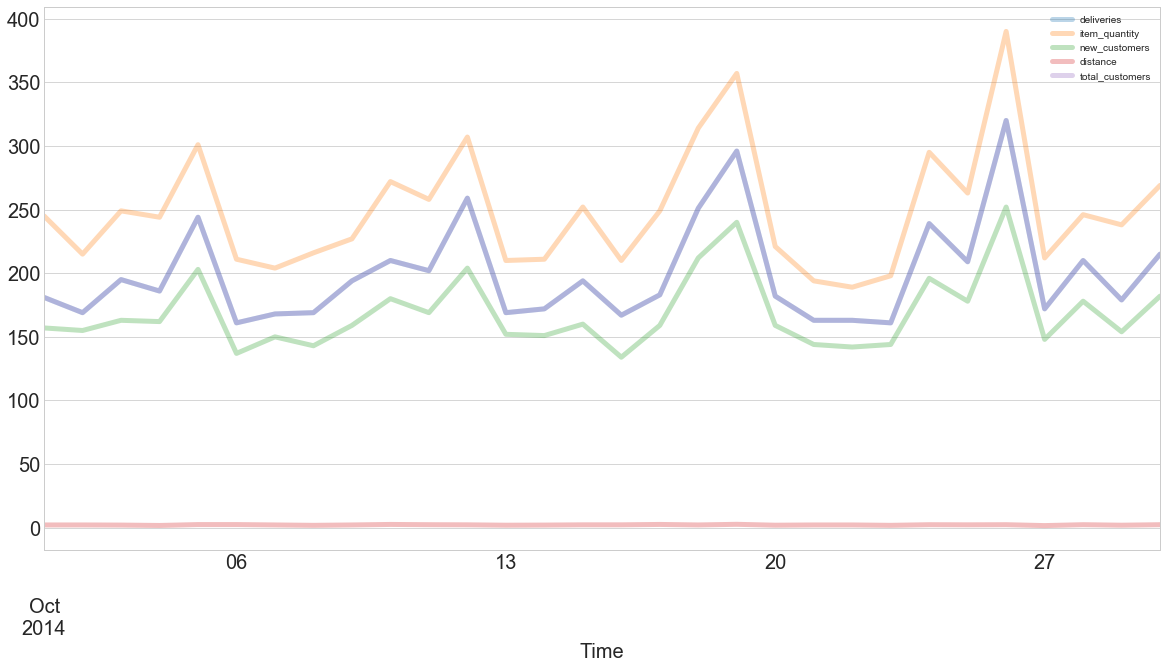

In [127]:


df_chart.plot(figsize=(20,10), linewidth=5, fontsize=20, alpha=0.3)
plt.xlabel('Time', fontsize=20);
plt.style.use('seaborn-whitegrid')



In [215]:
orders_sum = df_chart['delivery_id'].sum()
orders_mean = df_chart['delivery_id'].mean()

quantity_sum = df_chart['item_quantity'].sum()
unique_customer_sum = df_chart['customer_id'].sum()


In [205]:
sum_orders

5983

In [210]:
quantity_mean

7451

In [212]:
unique_customer_sum

5067

In [56]:
df_category = df[['delivery_id', 'customer_id', 'item_quantity', 'place_category']].copy()

In [155]:
df_category_groupby

df_category_groupby = df_category.groupby(df['place_category']).agg({'delivery_id':'count', 'item_quantity': 'sum', 'customer_id': 'nunique'})

df_category_groupby.reset_index()


place_category  delivery_id  item_quantity  customer_id
0                 African            1       1.000000            1
1                American          405     512.420144          286
2               Art Store            1       1.248264            1
3                   Asian           11      11.496528           10
4                     BBQ          134     148.993056          104
5                  Bakery          140     202.703128          114
6           Beauty Supply            2       2.496528            2
7              Book Store            1       1.248264            1
8               Breakfast           48      58.482640           41
9                  Burger          454     598.972224          338
10              Caribbean            7       7.000000            6
11                Chinese          332     372.434032          248
12               Clothing            1       1.248264            1
13                 Coffee           61      75.944448           47
14      Convenience Store           19      26.489584           16
15                   Deli           65      79.986112           52
16       Department Store            9      11.234376            9
17                Dessert          315     439.972224          251
18                  Donut           90     126.737848           64
19             Drug Store           68      84.881952           64
20       Eastern European           16      20.248264            8
21      Electronics Store           19      23.717016           19
22              Fast Food           83     104.930560           60
23             Food Truck           18      22.496528           17
24                 French           30      35.248264           22
25                 German            4       4.000000            4
26            Gluten-Free           68      77.489584           40
27          Grocery Store          187     237.965280          120
28              Ice Cream           55      64.710072           44
29                 Indian           91     127.496528           67
30                Italian          504     560.633688          381
31               Japanese          433     557.199656          275
32              Juice Bar           99     140.723960           71
33            Kids & Baby            3       3.744792            3
34                 Korean           21      22.744792           17
35          Mediterranean           69      83.986112           54
36                Mexican          178     208.371536          150
37         Middle Eastern           70      76.248264           48
38  Office Supplies Store            5       6.241320            5
39     Pet Supplies Store            1       1.248264            1
40                  Pizza          106     128.730904           88
41                  Promo           19      26.248264           19
42             Restaurant            1       1.248264            1
43                Russian            9      10.000000            8
44                  Salad          206     236.434032          153
45                Seafood           81      98.737848           65
46                   Shop           43      55.496528           40
47         South American           38      43.000000           31
48               Southern           31      42.000000           18
49                Spanish           15      15.000000           10
50        Specialty Store            5       7.993056            5
51                  Steak           37      38.993056           29
52                  Sushi          253     327.723960          169
53                   Thai           36      40.482640           28
54                  Vegan           21      25.993056           15
55             Vegetarian           73      75.993056           50
56             Vietnamese            8       9.000000            6

In [179]:
top_deliveries = df_category_groupby.nlargest(5, ['delivery_id'])
bottom_deliveries = df_category_groupby.nsmallest(10, ['delivery_id'])

top_deliveries = top_deliveries.reset_index()
bottom_deliveries = bottom_deliveries.reset_index()

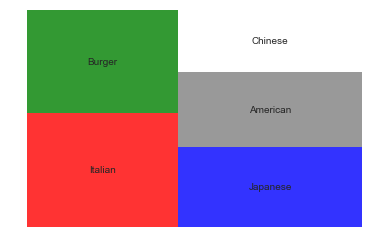

In [180]:
import squarify

squarify.plot(sizes=top_deliveries['delivery_id'],
                label=top_deliveries['place_category'],
              color=["red","green","blue", "grey", "white"], 
              alpha=.8 )
plt.axis('off')
plt.show() 

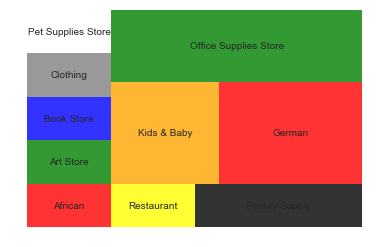

In [181]:
squarify.plot(sizes=bottom_deliveries['delivery_id'],
                label=bottom_deliveries['place_category'],
              color=["red","green","blue", "grey", "white", "yellow", "black", "orange"], 
              alpha=.8 )
plt.axis('off')
plt.show() 

In [150]:
df_vehicle = df[['delivery_id', 'customer_id', 'item_quantity', 'vehicle_type']].copy()

In [165]:
df_vehicle_groupby = df.groupby(df['vehicle_type']).agg(
    {'delivery_id':'count', 'item_quantity': 'sum', 'customer_id': 'nunique', 'distance': 'mean'})

In [182]:
top_vehicle = df_vehicle_groupby.nlargest(5, ['delivery_id'])
bottom_vehicle = df_vehicle_groupby.nsmallest(10, ['delivery_id'])
top_vehicle = top_vehicle.reset_index()
bottom_vehicle = bottom_vehicle.reset_index()

In [184]:
df_vehicle_groupby

delivery_id  item_quantity  customer_id  distance
vehicle_type                                                   
bicycle              4274    5349.444544         2501  1.949429
car                  1215    1513.611136          893  3.204869
motorcycle             21      24.993056           19  3.609047
scooter                75      85.723960           64  2.634464
truck                  48      55.993056           38  4.889713
van                    76      99.710072           68  2.507458
walker                274     338.888896          226  2.169501

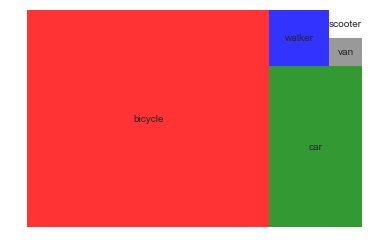

In [175]:
squarify.plot(sizes=top_vehicle['delivery_id'],
                label=top_vehicle['vehicle_type'],
              color=["red","green","blue", "grey", "white"], 
              alpha=.8 )
plt.axis('off')
plt.show() 

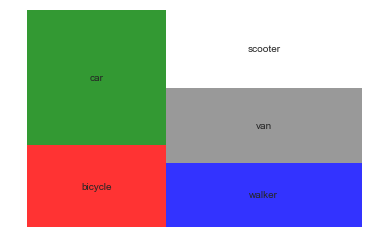

In [183]:
squarify.plot(sizes=top_vehicle['distance'],
                label=top_vehicle['vehicle_type'],
              color=["red","green","blue", "grey", "white"], 
              alpha=.8 )
plt.axis('off')
plt.show() 

In [187]:
top_vehicle

vehicle_type  delivery_id  item_quantity  customer_id  distance
0      bicycle         4274    5349.444544         2501  1.949429
1          car         1215    1513.611136          893  3.204869
2       walker          274     338.888896          226  2.169501
3          van           76      99.710072           68  2.507458
4      scooter           75      85.723960           64  2.634464